In [3]:
# torch and torchvision imports

import torch, torch.nn as nn, torch.optim as optim
from torchmetrics.classification import MultilabelAUROC
import numpy as np,  matplotlib.pyplot as plt, pandas as pd, pickle
from torchinfo import summary
from torch.utils.tensorboard import SummaryWriter
from ResnetModel import *
from transformer import *
writer = SummaryWriter()
# from google.colab import drive
# drive.mount('/gdrive')
torch.set_default_dtype(torch.float32)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")


Device: cuda


### Loading and Preparing Data

In [4]:
X_train = torch.from_numpy(np.transpose(np.load('./data/X_train.npz')['arr_0'], axes = (0,2,1))).float()
X_test = torch.from_numpy(np.transpose(np.load('./data/X_val.npz')['arr_0'], axes = (0,2,1))).float()
y_train = pd.read_csv('./data/Y_train.csv')[['Diag', 'Form', 'Rhythm']].to_numpy()
y_test = pd.read_csv('./data/Y_val.csv')[['Diag', 'Form', 'Rhythm']].to_numpy()

/tmp/ipykernel_68653/265309155.py:3: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  y_train = pd.read_csv('./data/Y_train.csv')[['Diag', 'Form', 'Rhythm']].to_numpy()


In [5]:
y_train = torch.from_numpy(y_train).int()
y_test = torch.from_numpy(y_test).int()

In [6]:
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
x = X_train[0:1]
print(x.shape)

torch.Size([1, 12, 1000])


### Creating the Resnet Model

In [10]:
"""Transformer needs X input as (seq_len, batch_size, channels)"""
model = ResNet(Bottleneck, [3, 4, 23, 3], num_classes=6).float()
# resnetModel = ResNet(Bottleneck, [3, 4, 23, 3], num_classes=6).to(device)

# resnetModel(X_train[0:1].to(device))
print(summary(model.to(device), (1,12, 200)))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 6]                    --
├─Conv1d: 1-1                            [1, 64, 100]              5,376
├─ReLU: 1-2                              [1, 64, 100]              --
├─BatchNorm1d: 1-3                       [1, 64, 100]              128
├─MaxPool1d: 1-4                         [1, 64, 50]               --
├─Sequential: 1-5                        [1, 256, 50]              --
│    └─Bottleneck: 2-1                   [1, 256, 50]              --
│    │    └─Conv1d: 3-1                  [1, 64, 50]               4,096
│    │    └─ReLU: 3-2                    [1, 64, 50]               --
│    │    └─BatchNorm1d: 3-3             [1, 64, 50]               128
│    │    └─Conv1d: 3-4                  [1, 64, 50]               12,288
│    │    └─ReLU: 3-5                    [1, 64, 50]               --
│    │    └─BatchNorm1d: 3-6             [1, 64, 50]               128
│ 

In [11]:
(4*1024-23.86)/124.66 #Max batch size

32.66597144232312

In [12]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 64, shuffle=True)

In [13]:
"""Test AUC metric"""
ml_auroc = MultilabelAUROC(num_labels=3, average="macro", thresholds=None)
# ml_auroc(model(X_train[0:10].to(device)), train_label_mapping[0:10].to(device).int())

### Finding Max Learning rate

In [19]:
criterion = nn.BCELoss()
epochs = 10
model = ResNet(Bottleneck, [3, 4, 23, 3], num_classes=3).to(device)
lr = 1e-6
optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay=1e-4)

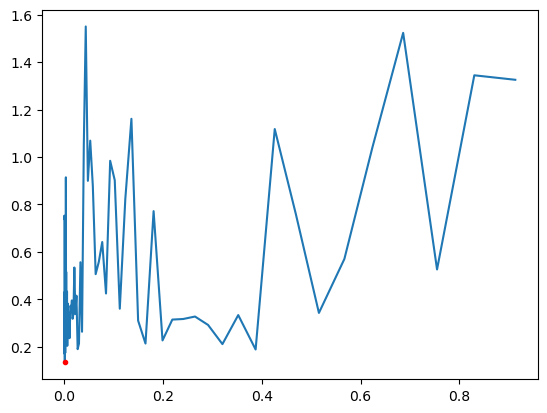

In [20]:
train_loss = []
lrs = []

for i, (signal, labels) in enumerate(train_loader):
    idx = np.random.randint(0, 1000-200)
    signal = (signal[:, :, idx:idx+200]).to(device)
    labels = labels.to(device)
    output = model(signal)
    loss = criterion(output, labels.float())
    optimizer.zero_grad()
    loss.backward()
    train_loss.append(loss.item())
    lrs.append(lr)
    lr *= 1.1

    for g in optimizer.param_groups:
        g['lr'] = lr 

    optimizer.step()

    if i > 200 or lr > 1:
        break

lrs = np.array(lrs)
train_loss = np.array(train_loss)

lr_max = lrs[np.where(train_loss == train_loss.min())[0]]

fig = plt.figure()
plt.plot(lrs, train_loss)
plt.plot(lr_max, train_loss[lrs == lr_max], '.r')
plt.show()


In [18]:
output.shape

torch.Size([64, 6])

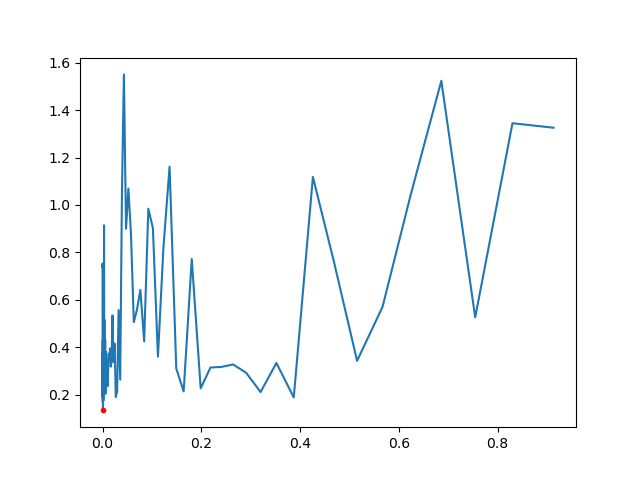

In [21]:
%matplotlib widget
fig = plt.figure()
plt.plot(lrs, train_loss)
plt.plot(lr_max, train_loss[lrs == lr_max], '.r')
plt.show()

In [ ]:
%matplotlib widget
fig = plt.figure()
plt.plot(lrs, train_loss)
plt.plot(lr_max, train_loss[lrs == lr_max], '.r')
plt.show()

In [ ]:
lr_max

In [12]:
lr_max = 0.0025/10
lr = lr_max
epochs = 100
criterion = nn.BCELoss()
model = ResNet(Bottleneck, [3, 4, 23, 3], num_classes=6).to(device)
optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay=1e-4)

for g in optimizer.param_groups:
    g['lr'] = lr

/home/anirudhkailaje/.local/lib/python3.11/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


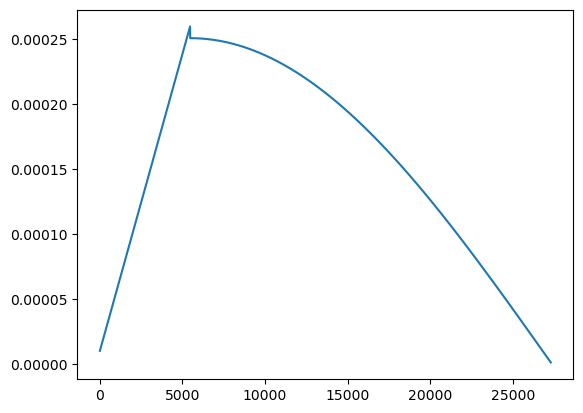

In [13]:
lrs = []
t = 0
steps_per_epoch = len(train_loader)
T_max = steps_per_epoch*epochs
T_0 = T_max/5 
for t in range(T_max):
    if t <= T_0:
        lr = 10**(-5) + (t/T_0)*lr_max  
    else: 
        lr = lr_max*np.cos((np.pi/2)*((t-T_0)/(T_max-T_0))) + 10**(-6)
    lrs.append(lr)

fig = plt.figure()
plt.plot(lrs)
plt.show()


In [14]:
lr =lr_max

In [15]:
len(range(0,800,20))

40

In [16]:
t = 0
steps_per_epoch = len(train_loader)
T_max = steps_per_epoch*epochs
T_0 = T_max/5 
learning_rates = []
train_losses = []

for epoch in range(epochs):
    for i, (signal, labels) in enumerate(train_loader):
        idx = np.random.randint(0, 1000-200)
        signal_sample = (signal[:, :, idx:idx+200]).to(device).transpose(0,1).transpose(0,2)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(signal_sample)
        loss = criterion(outputs, labels.float())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 5)
        if t <= T_0:
            lr = 10**(-4) + (t/T_0)*lr_max  
        else: 
            lr = lr_max*np.cos((np.pi/2)*((t-T_0)/(T_max-T_0))) + 10**(-6) 

        for g in optimizer.param_groups:
            g['lr'] = lr 
        learning_rates.append(lr)
        train_losses.append(loss.item())
        optimizer.step()
        t+=1
        
        train_AUC = ml_auroc(outputs, labels.int())
        writer.add_scalar("Train_Loss", loss, t)
        writer.add_scalar("Learning rate", lr, t)
        writer.add_scalar("Batch Train AUC", train_AUC, t)

        if i%(len(train_loader)//10) == 0:
            print(f"Step: {i+1}/{len(train_loader)}  |  Train loss: {loss.item():.4f}  |  Train AUC: {train_AUC:.4f}")
           

    # model.eval()
    test_auc = 0
    with torch.no_grad():
        for i, (signal, labels) in enumerate(test_loader):
            idx = np.random.randint(0, 1000-200)
            signal = (signal[:, :, idx:idx+200]).to(device).transpose(0,1).transpose(0,2)
            labels = labels.to(device)
            outputs = model(signal)
            test_auc += ml_auroc(outputs, labels.int())
        test_auc /= len(test_loader)
    writer.add_scalar("Test AUC", test_auc, epoch)

Step: 1/273  |  Train loss: 0.6477  |  Train AUC: 0.5333
Step: 28/273  |  Train loss: 0.4529  |  Train AUC: 0.3738
Step: 55/273  |  Train loss: 0.3708  |  Train AUC: 0.4944
Step: 82/273  |  Train loss: 0.4150  |  Train AUC: 0.5683
Step: 109/273  |  Train loss: 0.4013  |  Train AUC: 0.2659
Step: 136/273  |  Train loss: 0.3912  |  Train AUC: 0.3811
Step: 163/273  |  Train loss: 0.3220  |  Train AUC: 0.3438
Step: 190/273  |  Train loss: 0.3151  |  Train AUC: 0.4956
Step: 217/273  |  Train loss: 0.3438  |  Train AUC: 0.2886
Step: 244/273  |  Train loss: 0.3436  |  Train AUC: 0.6379
Step: 271/273  |  Train loss: 0.2989  |  Train AUC: 0.2144
Step: 1/273  |  Train loss: 0.3681  |  Train AUC: 0.6625
Step: 28/273  |  Train loss: 0.3534  |  Train AUC: 0.2179
Step: 55/273  |  Train loss: 0.3433  |  Train AUC: 0.3748
Step: 82/273  |  Train loss: 0.2964  |  Train AUC: 0.6836
Step: 109/273  |  Train loss: 0.4044  |  Train AUC: 0.4882
Step: 136/273  |  Train loss: 0.4249  |  Train AUC: 0.4156
Step: 1

In [2]:
lr

NameError: name 'lr' is not defined

In [13]:
t

34492

In [14]:
with open('superclassmodel.pickle', 'wb') as f:
    pickle.dump(model, f)